In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer


In [66]:
df = pd.read_csv("rfm_data.csv")
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.362078,3.246729,3.335819
2,-1.159515,3.199668,3.303571
3,-0.066541,1.111702,3.296366
4,-1.521525,3.402762,3.397240
...,...,...,...
62983,0.738089,-5.199338,-2.511791
62984,-0.111890,-0.494971,-0.185108
62985,-0.683178,-5.199338,-1.373926
62986,1.035790,-5.199338,-0.882739


In [13]:
# Return K_MEANS dengan cluster_id dan distance to centroid
def cluster_maker(dataframe, n_cluster_lts):
    kmeans = KMeans(n_clusters=n_cluster_lts, init='k-means++', random_state=42).fit(dataframe)

    dataframe['distance_to_centroid'] = np.min(kmeans.transform(dataframe), axis=1)
    dataframe['cluster_id'] = kmeans.labels_

    return dataframe

In [67]:
# Memisahkan dataframe & mengurutkan berdasarkan distance
def separate_dataframe(dataframe, n_cluster_lts, sort_column='distance_to_centroid'):
    cluster_dfs = {}

    for i in range(n_cluster_lts):
        cluster_dfs[i] = [dataframe[dataframe['cluster_id'] == i]]
        cluster_dfs[i][0] = cluster_dfs[i][0].sort_values(sort_column, ascending=False)
        
    return cluster_dfs

In [90]:
def trim_outliers_from_clusters(df, n_cluster_lts, n_percent):
    clustered_df = cluster_maker(df, n_cluster_lts)
    cluster_dict = separate_dataframe(clustered_df, n_cluster_lts)
    inliers_dfs = []
    outliers_dfs = []

    for cluster_id, df_list in cluster_dict.items():
        # Mengurutkan DataFrame berdasarkan distance_to_centroid secara descending
        sorted_df = df_list[0].sort_values(by='distance_to_centroid', ascending=False)

        # Menghitung jumlah baris yang akan di-trim
        n_rows_to_trim = int(n_percent / 100 * len(sorted_df))

        # Memisahkan inliers dan outliers
        inliers_df = sorted_df.iloc[n_rows_to_trim:]
        outliers_df = sorted_df.iloc[:n_rows_to_trim]

        # Menambahkan cluster_id-out ke outliers
        outliers_df['cluster_id'] = str(cluster_id) + '-out'

        # Menyimpan DataFrame inliers dan outliers
        inliers_dfs.append(inliers_df)
        outliers_dfs.append(outliers_df)

    # Menggabungkan DataFrame inliers dari semua cluster sesuai dengan index awal
    inliers_result = pd.concat(inliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Menggabungkan DataFrame outliers dari semua cluster
    outliers_result = pd.concat(outliers_dfs).drop(columns=['distance_to_centroid'])

    # Return hasil clustering inliers+outliers sesuai dengan index awal
    optimal_cluster = pd.concat([inliers_result, outliers_result], axis=0).sort_index()

    return inliers_result, optimal_cluster

c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jptri\AppData\Local\Temp\ipykernel_21704\1008202634.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['cluster_id'] = str(cluster_id) + '-out'
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Prog

<Figure size 800x800 with 0 Axes>

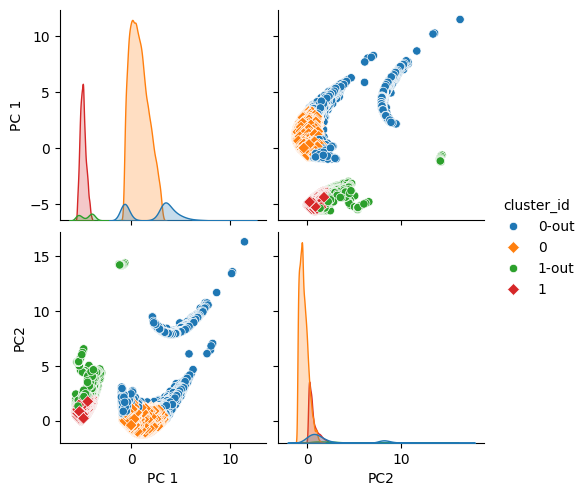

<Figure size 800x800 with 0 Axes>

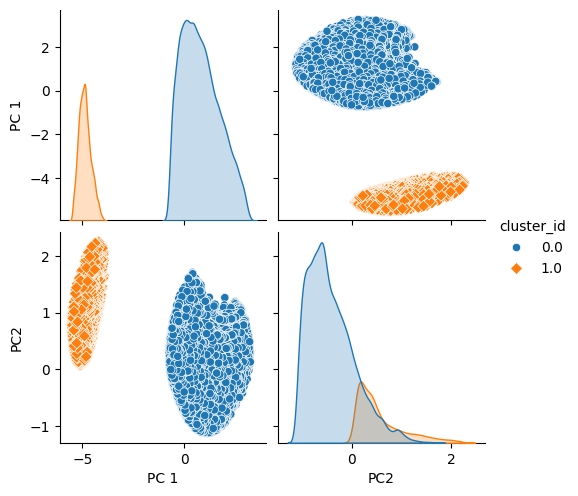

In [91]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])

# GET inliers (LTS_result_filtered) and optimal cluster (LTS_result)
LTS_result_filtered, LTS_result = trim_outliers_from_clusters(df_scaled, 2, 10)

# PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = LTS_result.loc[:, LTS_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = LTS_result_filtered.loc[:, LTS_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

In [ ]:
def best_percentage(dataframe, n_cluster_lts):
    best_silhouette_score = 0
    best_trimmed_df = None
    best_trim_percent = 0
    best_inliers = None
    best_outliers = None

    for percent in range(5, 35, 5):
        inliers, outliers = trim_outliers_from_clusters(dataframe=dataframe, n_cluster_lts=n_cluster_lts, trim_percent=percent)

        if inliers is not None:

            relevant_cols = inliers.iloc[:, :-2]
            labels = inliers.iloc[:, -1]
            score = silhouette_score(relevant_cols, labels)

            if score > best_silhouette_score:
                best_silhouette_score = score
                best_trim_percent = percent
                
                outliers['cluster_id'] = outliers.iloc[:, -1].replace(to_replace=(0, 1), value=("0-out", "1-out"))
                best_inliers = inliers
                best_outliers = outliers
    
    
    best_trimmed_df = pd.concat([best_inliers, best_outliers], axis=0)

    return best_trim_percent, best_silhouette_score, best_trimmed_df

In [ ]:
def K_MEANS_LTS(dataframe, n_cluster_lts):
    df_cluster = cluster_maker(dataframe=dataframe, n_cluster_lts=n_cluster_lts)
    best_trim_percent, best_silhouette_score, best_df = best_percentage(df_cluster, n_cluster_lts=n_cluster_lts)

    return best_trim_percent, best_silhouette_score, best_df

best_percent, best_silhouette_score, best_trimmed_df = K_MEANS_LTS(df, 2)
print("Best Percentage: ", best_percent)
print("Best Silhouette Score: ", best_silhouette_score)
print("=================================")
best_trimmed_df

In [ ]:
best_trimmed_df.drop('distance_to_centroid', axis=1, inplace=True)

In [ ]:
import seaborn as sns 

plt.figure(figsize=(8,8))
sns.pairplot(data=best_trimmed_df, hue='cluster_id')

In [ ]:
best_trimmed_df_filtered = best_trimmed_df.loc[~best_trimmed_df['cluster_id'].isin(["1-out", "0-out"]), :]
best_trimmed_df_filtered

In [ ]:
best_trimmed_df

In [ ]:
df_real = df.loc[:, df.columns.isin(['LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM'])]
df_real

In [ ]:
best_trimmed_df

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_real)

df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_pca['cluster_id'] = best_trimmed_df['cluster_id']
df_pca